# P5 - Vehicle Detection and Tracking

In this project I created a vehicle tracking pipeline using supervised learning algorithms on image related features from a vehicle dataset.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from utils.imread_rgb import imread_rgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## 1. Classification

The first step in solving the problem of identifying and tracking vehicles is to implement a binary classification algorithm which is capable of distinguishing between vehicles and non-vehicles. To implement this algorithm, i extracted gradient, color and spatial features from images and evaluated various standard classification algorithms from the sklearn toolkit.

In [2]:
vehicle_files = glob.glob('vehicles/*/*.png')
non_vehicle_files = glob.glob('non-vehicles/*/*.png')
vehicle_images = [imread_rgb(im) for im in vehicle_files]
nonvehicle_images = [imread_rgb(im) for im in non_vehicle_files]

In [3]:
images = np.vstack((vehicle_images, nonvehicle_images))
del vehicle_images
del nonvehicle_images

In [4]:
labels = np.hstack((np.ones(len(vehicle_files)), np.zeros(len(non_vehicle_files))))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels)

### 1.1. Feature Selection
There are multiple techniques to extract features from a given image. I decided to evaluate a handful of techniques by changing color space and various parameters of the feature extraction algorithms and comparing how well they train a linear SVM.
To compare the quality of the features I evaluated the f1_score metric which is a weighted average or the precision, recall scores of the classification algorithm.

#### 1.1.1 HOG features
The Histogram of Gradient (HOG) is a feature descriptor found in traditional computer vision techniques. The technique counts occurences of gradient orientations in a localized portion of a given image, the main idea of the algorithm is that shapes of objects in an image can be described by these gradient orientations are thus considered useful. I used the ```skimage.feature.hog``` function to extract hog features from the images and determine which parameters seem to work best.


In [6]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from feature_extractors.hog_extractor import extract_hog_features

In [11]:
color_spaces = ['RGB','HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
print('color_space \t orient \t pix_per_cell \t channel \t f1_score')
for color_space in color_spaces:
    X_train_features = []
    X_test_features = []
    for im in X_train:
        X_train_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))
    for im in X_test:
        X_test_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))

    X_train_features = np.asarray(X_train_features).astype(np.float64)
    X_test_feature = np.asarray(X_test_features).astype(np.float64)
    clf = LinearSVC()
    clf.fit(X_train_features, y_train)
    y_preds = clf.predict(X_test_features)
    f1 = f1_score(y_test, y_preds)
    print('{} \t{} \t{} \t{} \t{} : \t{}'.format(color_space, orient,  pix_per_cell, cell_per_block, channel, f1))
                    

color_space 	 orient 	 pix_per_cell 	 channel 	 f1_score
RGB 	9 	8 	2 	ALL : 	0.9741596158243769
HSV 	9 	8 	2 	ALL : 	0.9829196082896835
LUV 	9 	8 	2 	ALL : 	0.9824641311774084
HLS 	9 	8 	2 	ALL : 	0.9842717118759973
YUV 	9 	8 	2 	ALL : 	0.9858705560619873
YCrCb 	9 	8 	2 	ALL : 	0.9851632047477744


In [12]:
color_space = 'RGB'
orients = [5,7,9,13,16]
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
print('color_space \t orient \t pix_per_cell \t channel \t f1_score')
for orient in orients:
    X_train_features = []
    X_test_features = []
    for im in X_train:
        X_train_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))
    for im in X_test:
        X_test_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
        hog_channel=channel))

    X_train_features = np.asarray(X_train_features).astype(np.float64)
    X_test_feature = np.asarray(X_test_features).astype(np.float64)
    clf = LinearSVC()
    clf.fit(X_train_features, y_train)
    y_preds = clf.predict(X_test_features)
    f1 = f1_score(y_test, y_preds)
    print('{} \t{} \t{} \t{} \t{} : \t{}'.format(color_space, orient,  pix_per_cell, cell_per_block, channel, f1))
                    

color_space 	 orient 	 pix_per_cell 	 channel 	 f1_score
RGB 	5 	8 	2 	ALL : 	0.9611872146118721
RGB 	7 	8 	2 	ALL : 	0.9699747879899153
RGB 	9 	8 	2 	ALL : 	0.9741596158243769
RGB 	13 	8 	2 	ALL : 	0.9727376861397481
RGB 	16 	8 	2 	ALL : 	0.9715726730857405


From the exploration above I find that the hog features in the YUV space should give a better performance.
I also find that the optimal number of orients is 9 in the RGB space, so i train a svm on YUV space with 9 orients to evaluate the results

In [16]:
color_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
X_train_features = []
X_test_features = []
for im in X_train:
    X_train_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel))
for im in X_test:
    X_test_features.append(extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel))

X_train_features = np.asarray(X_train_features).astype(np.float64)
X_test_feature = np.asarray(X_test_features).astype(np.float64)
clf = LinearSVC()
clf.fit(X_train_features, y_train)
y_preds = clf.predict(X_test_features)
f1 = f1_score(y_test, y_preds)
print(f1)

0.985870556062


#### 1.1.2 Color Features
I next explore features related to color, specifically color distribution of the images in various color spaces  and spatial binning of colors

In [8]:
from feature_extractors.bin_spatial import extract_color_features

In [9]:
color_spaces = ['RGB','HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
print('color_space \t spatial_size \t hist_bins \t hist_range \t f1_score')
for color_space in color_spaces:
    X_train_features = []
    X_test_features = []
    for im in X_train:
        X_train_features.append(extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range))
    for im in X_test:
        X_test_features.append(extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range))

    X_train_features = np.asarray(X_train_features).astype(np.float64)
    X_test_feature = np.asarray(X_test_features).astype(np.float64)
    X_scalar = StandardScaler().fit(np.vstack([X_train_features, X_test_features]))
    X_train_scaled = X_scalar.transform(X_train_features)
    X_test_scaled = X_scalar.transform(X_test_features)
    clf = LinearSVC()
    clf.fit(X_train_scaled, y_train)
    y_preds = clf.predict(X_test_scaled)
    f1 = f1_score(y_test, y_preds)
    print('{} \t{} \t{} \t{} : \t{}'.format(color_space, spatial_size,  hist_bins, hist_range, f1))

color_space 	 spatial_size 	 hist_bins 	 hist_range 	 f1_score
RGB 	(32, 32) 	32 	(0, 256) : 	0.9492070788324523
HSV 	(32, 32) 	32 	(0, 256) : 	0.9482163406214039
LUV 	(32, 32) 	32 	(0, 256) : 	0.9394650398873768
HLS 	(32, 32) 	32 	(0, 256) : 	0.940797051370652
YUV 	(32, 32) 	32 	(0, 256) : 	0.950338074143157
YCrCb 	(32, 32) 	32 	(0, 256) : 	0.947294776119403


I find that the YUV colorspace seems to be training the SVM the best, thus i decide to use the YUV color features as well as the YUV colorspace HOG descriptors to train my classification model.

In [13]:
color_space = 'YUV'
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 'ALL'
X_train_features = []
X_test_features = []
for im in X_train:
    hog_features = extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel)
    
    color_features = extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range)
    features = np.hstack(
        (np.asarray(hog_features).astype(np.float64), 
         np.asarray(color_features).astype(np.float64))
    )
    X_train_features.append(features)
for im in X_test:
    hog_features = extract_hog_features(im, cspace=color_space, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
    hog_channel=channel)
    
    color_features = extract_color_features(im, cspace=color_space, spatial_size=spatial_size, 
        hist_bins=hist_bins, hist_range=hist_range)
    features = np.hstack(
        (np.asarray(hog_features).astype(np.float64), 
         np.asarray(color_features).astype(np.float64))
    )
    X_test_features.append(features)

X_train_features = np.asarray(X_train_features).astype(np.float64)
X_test_feature = np.asarray(X_test_features).astype(np.float64)
X_scalar = StandardScaler().fit(np.vstack([X_train_features, X_test_features]))
X_train_scaled = X_scalar.transform(X_train_features)
X_test_scaled = X_scalar.transform(X_test_features)
clf = LinearSVC()
clf.fit(X_train_scaled, y_train)
y_preds = clf.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print(f1)

0.991825613079


#### 1.1.3 Feature Scaling
When combining the HOG features and color features we find that their scales do not match, this would result int the classifier getting biased results to a specific type of feature. To remove this i scaled the feature vectors using the standard scalar in sklearn

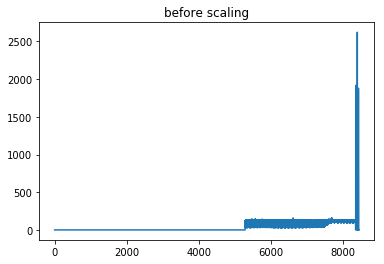

In [23]:
%matplotlib inline
plt.plot(X_train_features[0])
plt.title('before scaling')

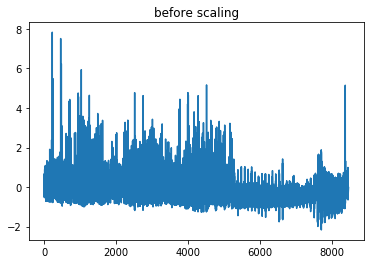

In [24]:
%matplotlib inline
plt.plot(X_train_scaled[0])
plt.title('before scaling')

### 1.2. Selecting a Classifier
Having determined features which can be used to train classification models. I decided to compare different classification models to determine which model to use for the final classifier.
the chosen models for comparison are :

1. LinearSVC
2. RandomForest
3. Bagging Ensemble of SVMs 

In [38]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [39]:
clfA = LinearSVC()
clfB = RandomForestClassifier()
clfC = GaussianNB()

clfA.fit(X_train_scaled, y_train)
y_preds = clfA.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print('clfA f1: {}'.format(f1))


clfB.fit(X_train_scaled, y_train)
y_preds = clfB.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print('clfB f1: {}'.format(f1))


clfC.fit(X_train_scaled, y_train)
y_preds = clfC.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print('clfC f1: {}'.format(f1))

clfA f1: 0.9918256130790191
clfB f1: 0.9859931113662457
clfC f1: 0.9649570666047806


After comparing a handful of classifiers , I found that the LinearSVC is given the best f1 score, thus I continued to use it as my classification algorithm.

## 1.3 Classifier Finetuning  

After determining the useful features and deciding on a specific classifier to use. I decided to use grid search to determine optimal parameters for the Linear SVM classifier for this specific problem.

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

parameters = {
    'C': [0.1, 1, 10, 100]
}

f1_scorer = make_scorer(f1_score)

grid_obj = GridSearchCV(LinearSVC(), 
                        param_grid=parameters,
                        scoring=f1_scorer)

grid_obj.fit(X_train_scaled, y_train)

clf = grid_obj.best_estimator_
y_preds = clf.predict(X_test_scaled)
f1 = f1_score(y_test, y_preds)
print(f1)

0.991825613079


after varying the C parameter for the linear SVC i found that it doesnt really affect the f1_score by much. I decided to use the Linear SVC as the final classifier for this project.

In [46]:
from sklearn.externals import joblib
joblib.dump(clf, 'final_clf.pkl') 
joblib.dump(X_scalar, 'feature_scaler.pkl')
feature_params = {
    color_space : 'YUV',
    spatial_size : (32,32),
    hist_bins : 32,
    hist_range : (0, 256),
    orient : 9,
    pix_per_cell : 8,
    cell_per_block : 2,
    channel : 'ALL'
}
joblib.dump(feature_params, 'feature_params.pkl')

['feature_params.pkl']

## 2. Sliding Window and Object Localization 